In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Evaluate the Encoder-Decoder models

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from utils import sample_files, encdec_files_to_tensors
from utils import get_best_model_timestamp
from utils import unnormalize_params, unnormalizeTurn
from models import encoderDecoderModel

data_dir = '/eos/user/k/kiliakis/tomo_data/datasets_decoder_02-12-22'
dataset_percent = 0.01
normalization = 'minmax'
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu',
             'VrfSPS']



2022-12-15 09:18:25.700441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 09:18:25.923102: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 09:18:25.966412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-12-15 09:18:25.966423: I tensorflow/st

In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent)

start_t = time.time()
# read input, divide in features/ label, create tensors
wf_test, turn_test, latent_test, ps_test = encdec_files_to_tensors(
    file_names, normalization=normalization)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


2022-12-15 09:18:31.694276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-12-15 09:18:31.694455: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 09:18:31.694471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-12-15 09:18:31.695184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 47.920, Per file: 0.076


In [22]:
# Models to load
# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'hybrid'

print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

dec_timestamp = '2022_12_14_22-03-08'
print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir)


Encoder:  hybrid
Decoder:  2022_12_14_22-03-08
enc_hybrid_dec2022_12_14_22-03-08


In [5]:

# Evaluate the model on the test and validation data
latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)

# Evaluate the latent space agreemet 
latent_mse = mean_squared_error(latent_test, latent_pred, multioutput='raw_values') 
print('Variable\tMSE')
for name, mse in zip(var_names, latent_mse):
    print(f'{name}:\t{mse:.3e}')

# Evaluate the PS agreement
ps_enc_dec_mse = np.mean((ps_test - ps_pred)**2, axis=0).reshape((128, 128))
print('\nPS Encoder-Decoder MSE: ', np.mean(ps_enc_dec_mse))

# Evaluate the PS agreement with perfect encoder
ps_dec_pred = encDec.decode(latent_test, turn_test)
ps_dec_mse = np.mean((ps_test - ps_dec_pred)**2, axis=0).reshape((128, 128))
print('\nPS Decoder MSE: ', np.mean(ps_dec_mse))



Variable	MSE
phEr:	2.537e-05
enEr:	2.013e-05
bl:	1.542e-04
inten:	8.340e-02
Vrf:	6.258e-05
mu:	7.897e-04
VrfSPS:	1.193e-03

PS Encoder-Decoder MSE:  0.0003913339

PS Decoder MSE:  0.00030164543


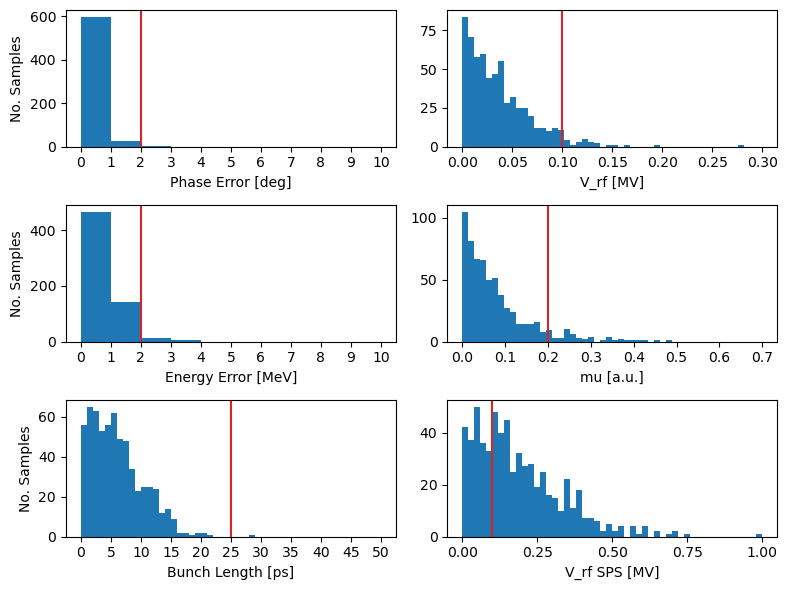

In [23]:
# Encoder, graphical evaluation

# unormalized latent space
latent_unnorm = unnormalize_params(
    latent_test[:, 0], latent_test[:, 1], latent_test[:, 2],
    latent_test[:, 3], latent_test[:, 4], latent_test[:, 5],
    latent_test[:, 6], normalization=normalization)
latent_unnorm = np.array(latent_unnorm).T

# unormalized predicted latent space
latent_pred_unnorm = unnormalize_params(
    latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
    latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
    latent_pred[:, 6], normalization=normalization)
latent_pred_unnorm = np.array(latent_pred_unnorm).T

# absolute difference
diffs = np.abs(latent_unnorm - latent_pred_unnorm)


fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))

plt.sca(axes[0][0])
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[1][0])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[2][0])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='tab:red')

plt.sca(axes[0][1])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.sca(axes[1][1])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.7))
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='tab:red')

plt.sca(axes[2][1])
plt.hist(diffs[:, 6], bins=50, range=(0, 1))
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'encoder_absError.jpg'), dpi=400)

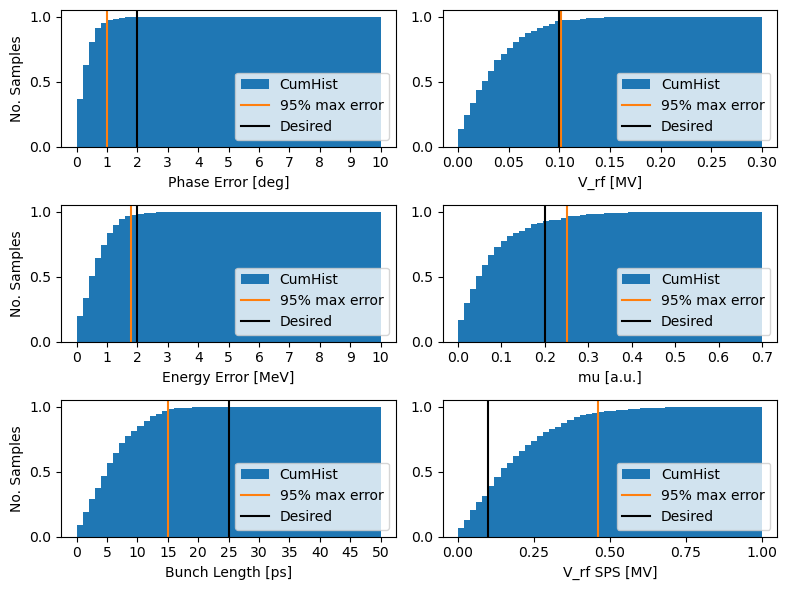

In [24]:
import bisect

'''
These plots are used for the evaluation of the encoder part. 
They show the cumulative distribution of absolute error. 
The black vertical line corresponds to the required prediction, i.e. ideally all
predictions would have less error than the required. 
The vertical orange line shows the 95th percentile, i.e. 95% of the test points 
have error less than this value.
If the orange line is to the left of the black line, it means that more than 95%
of the test points have less error than the required value.   
'''

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))

plt.sca(axes[0][0])
n, bins, patches = plt.hist(diffs[:, 0], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][0])
n, bins, patches = plt.hist(diffs[:, 1], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][0])
n, bins, patches = plt.hist(
    diffs[:, 2]*1e12, bins=50, range=(0, 50),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[0][1])
n, bins, patches = plt.hist(diffs[:, 4], bins=50, range=(0, 0.3),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][1])
n, bins, patches = plt.hist(diffs[:, 5], bins=50, range=(0, 0.7),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][1])
n, bins, patches = plt.hist(diffs[:, 6], bins=50, range=(0, 1),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'encoder_cumError.jpg'), dpi=400)

PS True, min: -1.0, max: 0.904047966003418
PS Pred, min: -1.0, max: 0.8288593888282776


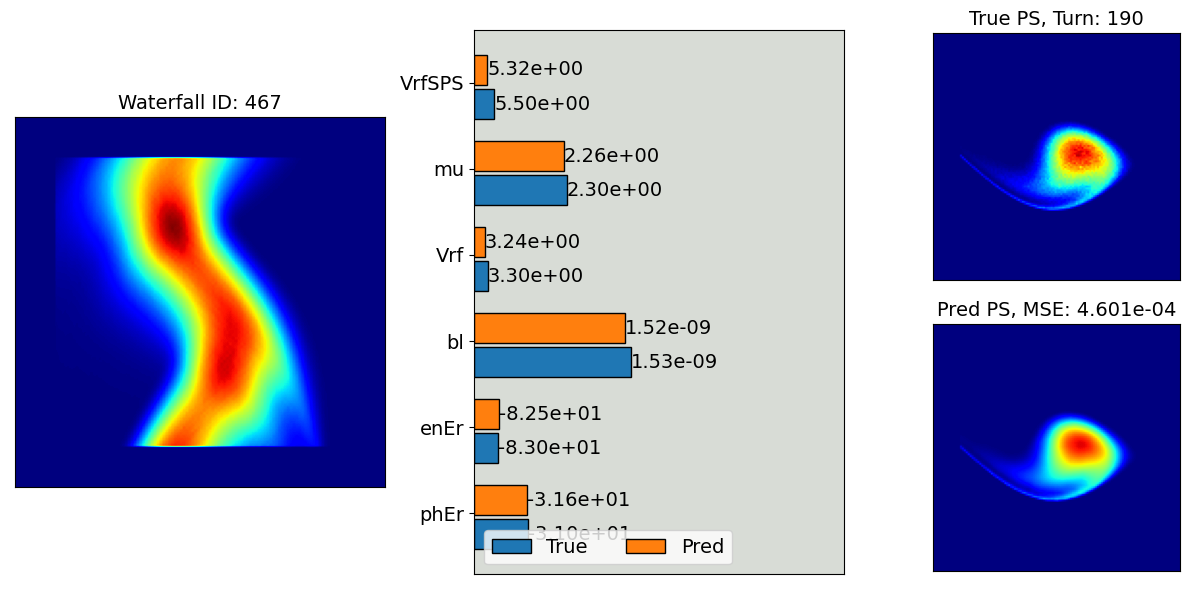

In [40]:
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'TAB', 'PS_TRUE'],
                                       ['WF', 'TAB', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 2]},
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(12, 6))

# get random id
sample_id = np.random.randint(low=0, high=len(file_names))
wf_s = np.array(wf_test[sample_id]).reshape(128, 128).T
latent_true_s = latent_unnorm[sample_id]
latent_pred_s = latent_pred_unnorm[sample_id]
latent_norm_true_s = np.array(latent_test[sample_id])
latent_norm_pred_s = np.array(latent_pred[sample_id])

turn_s = turn_test[sample_id]
turn_s = int(unnormalizeTurn(turn_s, maxTurns=300))
ps_true_s = ps_test[sample_id]
ps_pred_s = ps_pred[sample_id]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# center plot
plt.sca(axes['TAB'])
plt.gca().set_facecolor('xkcd:light grey')
# Remove inten, since it is very hard to predict
latent_true_s = np.delete(latent_true_s, var_names.index('inten'))
latent_pred_s = np.delete(latent_pred_s, var_names.index('inten'))
latent_norm_true_s = np.delete(latent_norm_true_s, var_names.index('inten'))
latent_norm_pred_s = np.delete(latent_norm_pred_s, var_names.index('inten'))

reduced_var_names = var_names.copy()
reduced_var_names.remove('inten')

bars = plt.barh(np.arange(len(latent_true_s)),
                height=0.35, width=(latent_norm_true_s),
                edgecolor='black', label='True')

for idx, width in enumerate(latent_norm_true_s):
    plt.annotate(f'{latent_true_s[idx]:.2e}',
                 xy=(width, idx),
                 ha='left', va='center',
                 fontsize=14)

plt.barh(np.arange(len(latent_true_s)) + 0.4,
         height=0.35, width=latent_norm_pred_s,
         edgecolor='black', label='Pred')

for idx, width in enumerate(latent_norm_pred_s):
    plt.annotate(f'{latent_pred_s[idx]:.2e}',
                 xy=(width, idx+0.4),
                 ha='left', va='center',
                 fontsize=14)
plt.xlim(0, 1.3)


plt.yticks(np.arange(len(latent_true_s))+0.25, reduced_var_names, fontsize=14)
plt.xticks([], [])
plt.legend(loc='lower left',fontsize=14, ncols=2)

# top right plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
plt.imshow(ps_true_s, cmap='jet', vmin=-1, vmax=1)
plt.title(f'True PS, Turn: {turn_s}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# bottom right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
plt.imshow(ps_pred_s, cmap='jet', vmin=-1, vmax=1)
plt.title(f'Pred PS, MSE: {np.mean((ps_pred_s - ps_true_s)**2):.3e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()

plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)
